In [56]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [57]:

# Read the dataset
data = pd.read_parquet('data.parquet')

# Handle missing values by interpolating
data = data.interpolate(method='linear')
data = data.between_time('09:15', '15:30')

print(data.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [58]:
# Calculate spread
data['Spread'] = data['banknifty'] - data['nifty']

data['P/L'] = data['Spread'] * (data['tte'] ** 0.7)

print(data[['Spread', 'P/L']].head())

                       Spread       P/L
time                                   
2021-01-01 09:15:00  0.086329  0.867184
2021-01-01 09:16:00  0.084948  0.853317
2021-01-01 09:17:00  0.084229  0.846089
2021-01-01 09:18:00  0.086244  0.866325
2021-01-01 09:19:00  0.086588  0.869786


In [59]:
# Calculate z-scores
data['Spread_Zscore'] = zscore(data['Spread'])

# Define entry and exit thresholds
entry_threshold = 1

# Generate signals
data['Signal'] = np.where(data['Spread_Zscore'] > entry_threshold, -1, np.where(data['Spread_Zscore'] < -entry_threshold, 1, 0))

data.head()

,banknifty,nifty,tte,Spread,P/L,Spread_Zscore,Signal
time,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184,0.543776,0
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317,0.491764,0
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089,0.464655,0
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325,0.540555,0
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786,0.553535,0


In [60]:
def calculate_pl(data):
    return data['P/L'].sum()

def calculate_sharpe_ratio(data):
    mean_return = data['P/L'].mean()
    std_dev = data['P/L'].std()
    sharpe_ratio = (mean_return / std_dev) * (252 ** 0.5)  # Assuming 252 trading days in a year
    return sharpe_ratio

def calculate_drawdown(data):
    cum_pnl = data['P/L'].cumsum()
    max_drawdown = (cum_pnl - cum_pnl.expanding().max()).min()
    return max_drawdown

base_model_pl = calculate_pl(data)
base_model_sharpe_ratio = calculate_sharpe_ratio(data)
base_model_drawdown = calculate_drawdown(data)
base_model_pl, base_model_sharpe_ratio, base_model_drawdown
print("Predicted Model Performance:")
print("Total Profit:", base_model_pl)
print("Sharpe Ratio:", base_model_sharpe_ratio)
print("Maximum Drawdown:", base_model_drawdown)

Predicted Model Performance:
Total Profit: 86321.02160308613
Sharpe Ratio: 27.393970439725493
Maximum Drawdown: -0.07677310948929517


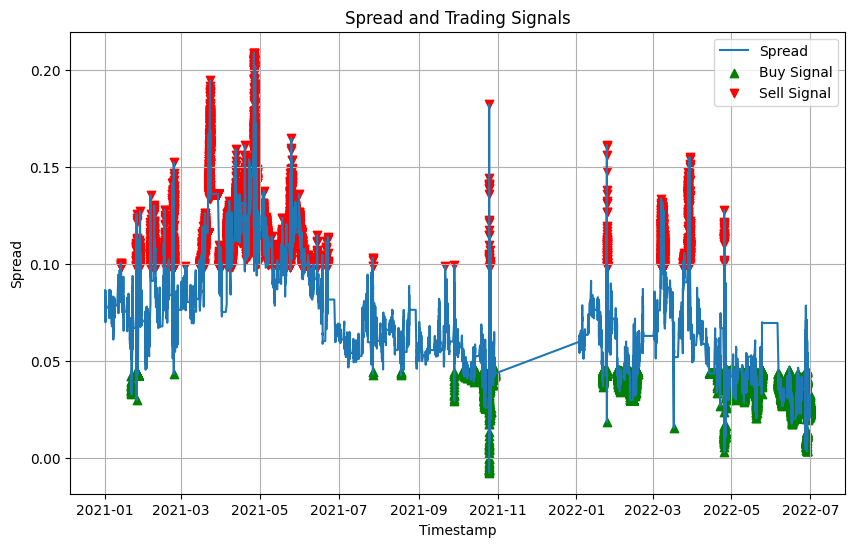

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Spread'], label='Spread')
plt.scatter(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['Spread'], marker='^', color='g', label='Buy Signal')
plt.scatter(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['Spread'], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title('Spread and Trading Signals')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.grid(True)
plt.show()

# LSTM model

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error


# Assuming 'Bank Nifty IV' and 'Nifty IV' are columns in the dataset
X = data[['banknifty', 'nifty', 'tte']]
y = data['Spread'] # Assuming 'Spread' is the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to fit LSTM model
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer= Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=25, batch_size=32, verbose=1)

# Predict the spread for test data
pred = model.predict(X_test_reshaped)
pred = pred.flatten()

# Generate trading signals based on predicted spread values
Signal_Predicted = np.where(pred > 0, 1, -1)

# Calculate P/L using predicted spread values
P_L_Predicted = pred * (X_test['tte'] ** 0.7)
# Evaluate model performance
predicted_model_profit = P_L_Predicted.sum()
predicted_model_sharpe_ratio = P_L_Predicted.mean() / P_L_Predicted.std()
predicted_model_drawdown = P_L_Predicted.cumsum().min()# Display predicted model performance
print("Predicted Model Performance:")
print("Total Profit:", predicted_model_profit)
print("Sharpe Ratio:", predicted_model_sharpe_ratio)
print("Maximum Drawdown:", predicted_model_drawdown)


Epoch 1/25
4522/4522 [==============================] - 6s 1ms/step - loss: 3.6426e-05
Epoch 2/25
4522/4522 [==============================] - 4s 965us/step - loss: 6.6181e-07
Epoch 3/25
4522/4522 [==============================] - 4s 995us/step - loss: 4.2079e-07
Epoch 4/25
4522/4522 [==============================] - 4s 981us/step - loss: 3.4171e-07
Epoch 5/25
4522/4522 [==============================] - 5s 1ms/step - loss: 2.8402e-07
Epoch 6/25
4522/4522 [==============================] - 5s 1ms/step - loss: 1.7093e-07
Epoch 7/25
4522/4522 [==============================] - 5s 1ms/step - loss: 1.4883e-07
Epoch 8/25
4522/4522 [==============================] - 5s 998us/step - loss: 1.4471e-07
Epoch 9/25
4522/4522 [==============================] - 5s 1ms/step - loss: 1.1221e-07
Epoch 10/25
4522/4522 [==============================] - 4s 982us/step - loss: 9.3790e-08
Epoch 11/25
4522/4522 [==============================] - 5s 997us/step - loss: 9.7583e-08
Epoch 12/25
4522/4522 [======

# Performance on entire dataset

In [91]:
pred = model.predict(X)
pred = pred.flatten()

# Generate trading signals based on predicted spread values
Signal_Predicted = np.where(pred > 0, 1, -1)

# Calculate P/L using predicted spread values
P_L_Predicted = pred * (X['tte'] ** 0.7)
# Evaluate model performance
lstm_model_profit = P_L_Predicted.sum()
lstm_model_sharpe_ratio = P_L_Predicted.mean() / P_L_Predicted.std()
lstm_model_drawdown = P_L_Predicted.cumsum().min()# Display predicted model performance
print("Predicted Model Performance:")
print("Total Profit:", lstm_model_profit)
print("Sharpe Ratio:", lstm_model_sharpe_ratio)
print("Maximum Drawdown:", lstm_model_drawdown)

5652/5652 [==============================] - 3s 469us/step
Predicted Model Performance:
Total Profit: 202730.33858176225
Sharpe Ratio: 1.416262458317246
Maximum Drawdown: 2.220305191310001


Base Model Performance:
Total Profit: 86321.02160308613
Sharpe Ratio: 27.393970439725493
Maximum Drawdown: -0.07677310948929517

LSTM Model Performance:
Total Profit: 202730.33858176225
Sharpe Ratio: 1.416262458317246
Maximum Drawdown: 2.220305191310001

Model Comparison:
Base Model vs. LSTM Model
Absolute P/L Improvement: 116409.31697867611
Sharpe Ratio Improvement: -25.977707981408248
Drawdown Difference: 2.297078300799296


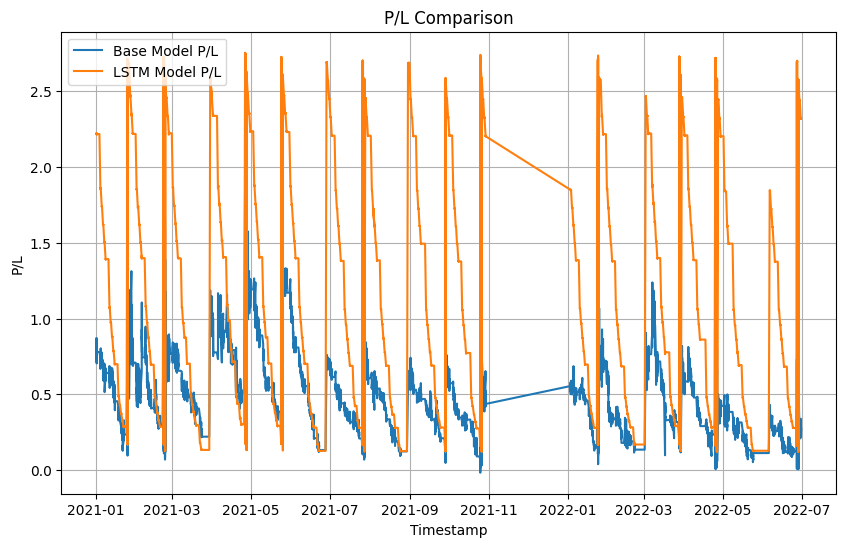

In [94]:
# Base model evaluation
print("Base Model Performance:")
print("Total Profit:", base_model_pl)
print("Sharpe Ratio:", base_model_sharpe_ratio)
print("Maximum Drawdown:", base_model_drawdown)

# LSTM model evaluation
print("\nLSTM Model Performance:")
print("Total Profit:", lstm_model_profit)
print("Sharpe Ratio:", lstm_model_sharpe_ratio)
print("Maximum Drawdown:", lstm_model_drawdown)

# Comparison
print("\nModel Comparison:")
print("Base Model vs. LSTM Model")
print("Absolute P/L Improvement:", lstm_model_profit - base_model_pl)
print("Sharpe Ratio Improvement:", lstm_model_sharpe_ratio - base_model_sharpe_ratio)
print("Drawdown Difference:", lstm_model_drawdown - base_model_drawdown)

# Additional insights
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['P/L'], label='Base Model P/L')
plt.plot(data.index, P_L_Predicted, label='LSTM Model P/L')
plt.legend()
plt.title('P/L Comparison')
plt.xlabel('Timestamp')
plt.ylabel('P/L')
plt.grid(True)
plt.show()


Conclusion: 

While the LSTM Model generates higher total profits, it comes with increased risk and lower risk-adjusted returns compared to the Base Model.
Depending on the investor's risk tolerance and investment objectives, they may prefer one model over the other. The Base Model may be suitable for risk-averse investors looking for stable returns, while the LSTM Model may appeal to investors willing to tolerate higher risk for potentially higher rewards